# Modeling Kernel 

## Initialization

### Imports

In [1]:
import re
import gc
import os
import time
import torch
import random
import warnings
import operator
import itertools
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import torch.utils.data
import matplotlib.pyplot as plt

from numba import jit
from torchvision import models
from sklearn.metrics import *
from collections import Counter
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool, cpu_count
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold

sns.set_style('whitegrid')
warnings.simplefilter(action='ignore')

### Seeding

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [3]:
seed = 1029
seed_everything(seed)
begin = time.time()

### Paths

In [42]:
FEATURES_FOLDER = "../input/features" # Where created features are stored
DATA_FOLDER = "../input/data" # Where Kaggle data is stored
OUT_FOLDER = "../output" # Where to output results

## Processing Data

### Loading

In [5]:
y = pd.read_csv(F'{DATA_FOLDER}/metadata_train.csv')['target'].values

In [6]:
features_name = "dist"

In [10]:
X = np.load(f"{FEATURES_FOLDER}/X_{features_name}.npy")

print("Train shape : ", X.shape)

Train shape :  (8712, 160, 21)


In [9]:
X_test_1 = np.load(f"{FEATURES_FOLDER}/X_test_{features_name}_1.npy")
X_test_2 = np.load(f"{FEATURES_FOLDER}/X_test_{features_name}_2.npy")
X_test_3 = np.load(f"{FEATURES_FOLDER}/X_test_{features_name}_3.npy")

X_test = np.concatenate([X_test_1, X_test_2, X_test_3])
print("Test shape : ", X_test.shape)

Test shape :  (20337, 160, 21)


### Normalizing

In [11]:
def normalize(X, X_test=None):
    min_ = np.min(np.min(X, axis=0), axis=0)
    max_ = np.max(np.max(X, axis=0), axis=0)
    X = (X - min_) / (max_ - min_) 
    
    if X_test is not None: 
        X_test = (X_test - min_) / (max_ - min_)
        return X, X_test
    
    return X

In [12]:
X, X_test= normalize(X, X_test)

### Merging
We basically create our input here. The main idea is for each signal to create a 3 channel input with each channel corresponding to a phase. Our signal is labeled 1 if one of the phases has a fault.

In [13]:
def merge(X, y):
    X0 = X[::3][:, np.newaxis, :, :]  # phase 0
    X1 = X[1::3][:, np.newaxis, :, :] # phase 1
    X2 = X[2::3][:, np.newaxis, :, :] # phase 2
    
    X_merged = np.concatenate((X0, X1, X2), axis=1)
    y_merged = (np.sum((y[::3], y[1::3], y[2::3]), axis=0) > 1).astype(int)

    return X_merged, y_merged


In [14]:
X, y = merge(X, y)
X_test, _ = merge(X_test, np.zeros((X_test.shape[0])))

In [15]:
sample_size =  X.shape[1]
nb_features = X.shape[2]

print("Input shape :", X.shape)

Input shape : (2904, 3, 160, 21)


### Target Distribution

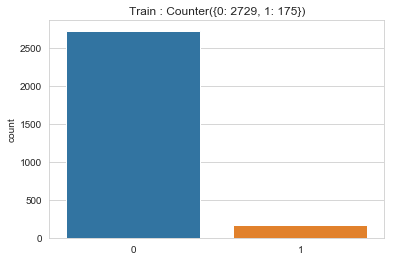

In [16]:
sns.countplot(y)
plt.title(f"Train : {Counter(y)}")
plt.show()

## Models

In [17]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2))
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(32 * 6 * 6, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(32, 1))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 32 * 6 * 6)
        x = self.classifier(x)
        return x

## Tools

### Sigmoid

In [18]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### Fast MCC

In [19]:
@jit
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)

@jit
def eval_mcc(y_prob, y_true):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    for i in range(n):  #change this to test fewer thresholds
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc and proba > 0.2:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
        if proba > 0.5:
            break
    return best_mcc, best_proba

### Checkpoints

In [22]:
def save_checkpoint(state, loss, best_loss, filename='checkpoint.pt'):
    if loss < best_loss:
        torch.save(state, filename)
        return True

In [23]:
def load_checkpoint(model, filename='checkpoint.pt'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['state_dict'])
    print("=> loaded checkpoint '{}' (trained for {} epochs)".format(filename, checkpoint['epoch']))

### Learning rate

In [24]:
def get_lr(epoch):
    if epoch <= 100:
        return 0.001
    else:
        return 0.0001

### Predict

In [25]:
def predict(X, model, batch_size=1024):
    y = np.array([])
    X = torch.tensor(X, dtype=torch.float32).cuda()
    X = torch.utils.data.TensorDataset(X)
    X_loader = torch.utils.data.DataLoader(X, batch_size=batch_size, shuffle=False)
    for i, (x,) in enumerate(X_loader):
        y = np.concatenate((y, sigmoid(model(x).detach().cpu().numpy())[:, 0]))
    return y

### Fit

In [26]:
def fit(model, X_train, y_train, X_val, y_val, epochs=5, batch_size=512, cp=False, cp_file="cp.pt", verbose=1):
    model.cuda()
    best_loss = 1000
    
    loss_fn = torch.nn.BCEWithLogitsLoss(reduction='sum')
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
        
    X_train = torch.tensor(X_train, dtype=torch.float32).cuda()
    y_train = torch.tensor(y_train[:, np.newaxis], dtype=torch.float32).cuda()
    train = torch.utils.data.TensorDataset(X_train, y_train)    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    
    X_val = torch.tensor(X_val, dtype=torch.float32).cuda()
    y_val = torch.tensor(y_val[:, np.newaxis], dtype=torch.float32).cuda()
    val = torch.utils.data.TensorDataset(X_val, y_val)
    val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        avg_loss = 0
        start_time = time.time()  
            
        lr = get_lr(epoch)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() / X_train.shape[0]
    
        model.eval()
        avg_val_loss = 0.

        for i, (x_batch, y_batch) in enumerate(val_loader):
            y_pred = model(x_batch).detach()
            avg_val_loss += loss_fn(y_pred, y_batch).item() / X_val.shape[0]

        if save_checkpoint({'epoch': epoch + 1, 'state_dict': model.state_dict()}, avg_val_loss, best_loss, filename=cp_file):
            best_loss = avg_val_loss
            
        elapsed_time = time.time() - start_time
        if (epoch + 1) % 5 * verbose == 0:
            print('Epoch {}/{} \t lr={} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s'.format(epoch+1, epochs, lr, avg_loss, avg_val_loss, elapsed_time))

### $k$-fold

In [27]:
def k_fold(model_class, X, y, X_test=[], k=5, batch_size=128, epochs=50, seed=2019, 
           verbose=1, cp=False, cp_file="cp.pt"):
    
    splits = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=seed).split(X, y))
    pred_test = np.zeros((X_test.shape[0]))
    pred_oof = np.zeros((y.shape[0]))
    histories = []
    
    for i, (train_idx, val_idx) in enumerate(splits):
        print(f"-------------   Fold {i+1}  ------------- \n")
        seed_everything(seed + i)
        start_time = time.time()
        
        model = model_class()
        history = fit(model, X[train_idx], y[train_idx], X[val_idx], y[val_idx], 
                      epochs=epochs, batch_size=batch_size, cp_file=cp_file, verbose=verbose)
        
        if cp:
            load_checkpoint(model, cp_file)

        pred_val = predict(X[val_idx], model)
        pred_oof[val_idx] = pred_val
        pred_test += predict(X_test, model) / k
        
        score = matthews_corrcoef(pred_val.flatten() > 0.5, y[val_idx].flatten())
        print(f"\n Scored {score :.4f} with threshold 0.5 on validation data")
        
        histories.append(history)
        print(f"\n    Done in {(time.time() - start_time) / 60 :.1f} minutes \n")
        
    return pred_test, pred_oof, histories

## Fitting

In [28]:
pred_test, pred_oof, histories = k_fold(Model, X, y, X_test, k=5, batch_size=128, epochs=150, seed=seed, cp=False)

-------------   Fold 1  ------------- 

Epoch 5/150 	 lr=0.001 	 loss=0.2285 	 val_loss=0.2289 	 time=0.37s
Epoch 10/150 	 lr=0.001 	 loss=0.2243 	 val_loss=0.2124 	 time=0.38s
Epoch 15/150 	 lr=0.001 	 loss=0.1568 	 val_loss=0.1545 	 time=0.38s
Epoch 20/150 	 lr=0.001 	 loss=0.1444 	 val_loss=0.1383 	 time=0.39s
Epoch 25/150 	 lr=0.001 	 loss=0.1268 	 val_loss=0.1269 	 time=0.38s
Epoch 30/150 	 lr=0.001 	 loss=0.1238 	 val_loss=0.1260 	 time=0.39s
Epoch 35/150 	 lr=0.001 	 loss=0.1187 	 val_loss=0.1172 	 time=0.39s
Epoch 40/150 	 lr=0.001 	 loss=0.1132 	 val_loss=0.1257 	 time=0.38s
Epoch 45/150 	 lr=0.001 	 loss=0.1190 	 val_loss=0.1140 	 time=0.38s
Epoch 50/150 	 lr=0.001 	 loss=0.1197 	 val_loss=0.1278 	 time=0.38s
Epoch 55/150 	 lr=0.001 	 loss=0.1036 	 val_loss=0.1168 	 time=0.39s
Epoch 60/150 	 lr=0.001 	 loss=0.1109 	 val_loss=0.1130 	 time=0.39s
Epoch 65/150 	 lr=0.001 	 loss=0.1042 	 val_loss=0.1067 	 time=0.39s
Epoch 70/150 	 lr=0.001 	 loss=0.1044 	 val_loss=0.1095 	 time=0

### Evaluating

#### Signal level

In [29]:
threshold = 0.5

In [30]:
score = matthews_corrcoef(pred_oof.flatten() > threshold, y.flatten())
print(f"Local MCC CV : {score:.3f}")

Local MCC CV : 0.670


#### Phase level

In [35]:
y_ = pd.read_csv(f'{DATA_FOLDER}/metadata_train.csv')['target'].values
pred_oof = np.repeat(pred_oof, 3)
pred_test = np.repeat(pred_test, 3)

In [36]:
score = matthews_corrcoef(pred_oof.flatten() > threshold, y_.flatten())
print(f"Local MCC CV : {score:.3f}")

Local MCC CV : 0.661


## Saving results

In [38]:
sub = pd.read_csv(f'{DATA_FOLDER}/sample_submission.csv')

In [39]:
sub["target"] = (pred_test > threshold).astype(int)

In [40]:
model_name = "final_sub"

In [43]:
sub.to_csv(f"{OUT_FOLDER}/submissions/{model_name}__{score:.3f}.csv", index=False)

In [44]:
print(f"Ended in {(time.time() - begin) / 60 :.1f} minutes")

Ended in 14.1 minutes
